#### First Imports

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop, SGD

#### Read the processed dataset

In [7]:
df = pd.read_csv("./processed_clustered_adhdata.csv")

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

display(df.head())

,ID,Class,Window,Frequency,Fp1,Fp2,F3,F4,C3,C4,...,Fz,Cz,Pz,Theta,Beta,Alpha,Fast_Alpha,High_Beta,TBR,TAR
0,v10p,2.0,0,2.0,25379.222437,13434.394810,1862.080149,3179.723538,1418.885236,5116.522701,...,2349.194501,5278.156628,935.215095,2903.203042,1487.330986,2252.515739,1170.997315,1192.159852,1.951955,1.288871
1,v10p,2.0,0,2.5,35351.096151,38485.847853,12025.897606,10262.779964,3309.949812,8056.793743,...,7086.393467,9269.600745,1175.976823,2903.203042,1487.330986,2252.515739,1170.997315,1192.159852,1.951955,1.288871
2,v10p,2.0,0,3.0,14038.273974,20836.960614,757.368253,376.379474,921.133295,1506.793907,...,682.922518,1298.915366,2283.822560,2903.203042,1487.330986,2252.515739,1170.997315,1192.159852,1.951955,1.288871
3,v10p,2.0,0,3.5,3299.722183,4801.627106,100.784086,589.982148,449.081281,2051.093618,...,166.249339,1869.041039,1080.292386,2903.203042,1487.330986,2252.515739,1170.997315,1192.159852,1.951955,1.288871
4,v10p,2.0,0,4.0,9601.231799,3313.402232,1438.078829,1473.695476,1717.483438,1573.801211,...,447.893661,890.015936,923.261576,2903.203042,1487.330986,2252.515739,1170.997315,1192.159852,1.951955,1.288871


#### Group the data

From a 2D matrix, we need to group each row according to their window number.
Furthermore, we add a dummy dimension for "channel", which is necessary for CNN, resulting in a shape of `(WINDOW_COUNT, FREQUENCY_PER_WINDOW, ELECTRODES)`

In [8]:
# shape: (windows, frequencies, electrodes)
full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

X = full_ndarray[:, :, 2:]     # drop ID/Class columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

print(X_train.shape)
print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)

(13399, 77, 26, 1)
Train shape: (13399, 77, 26, 1)


#### Dataset Loading

The EEG Dataset allows the automated extraction of the raw EEGs and the band powers.

In [11]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        # -> (N, 1, freq, electrodes)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]          # (1, 77, 26)

        x_eeg  = x[:, :, :19]    # (1, 77, 19)
        x_band = x[0, 0, 19:]    # (7,)

        return x_eeg, x_band, self.y[idx]

train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

#### Model Creation

In [12]:
import torch
import torch.nn as nn
import numpy as np

class EEGCNNLSTM(nn.Module):
    def __init__(self, num_band_features=7, num_classes=4,
                 cnn_kernels_1=32,
                 cnn_kernel_size_1=3,
                 cnn_kernels_2=32,
                 cnn_kernel_size_2=3,
                 cnn_dropout=0.3,
                 cnn_dense=16,
                 lstm_hidden_size=32,
                 lstm_layers=4,
                 lstm_dense=64,
                 dropout=0.3):
        super().__init__()
        
        pad1 = cnn_kernel_size_1 // 2
        self.conv1   = nn.Conv2d(1, int(cnn_kernels_1), kernel_size=cnn_kernel_size_1, padding=pad1)
        self.pool1 = nn.AvgPool2d(2)
        
        pad2 = cnn_kernel_size_2 // 2
        self.conv2 = nn.Conv2d(int(cnn_kernels_1), int(cnn_kernels_2), kernel_size=cnn_kernel_size_2, padding=pad2)
        self.cnn_dropout = nn.Dropout(cnn_dropout)

        # Compute flatten size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, X_train.shape[1], 19)
            out = self._forward_cnn(dummy)   # [B, C, H, W]
            b, c, h, w = out.shape
            self.seq_len = h                      # sequence length (rows)
            self.cnn_feat_dim = c * w             # CNN features per timestep

        # Dense layer BEFORE LSTM
        self.cnn_dense = nn.Linear(self.cnn_feat_dim, int(cnn_dense))

        # Two stacked LSTM layers
        self.lstm = nn.LSTM(
            input_size=int(cnn_dense),
            hidden_size=int(lstm_hidden_size),
            num_layers=int(lstm_layers),
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        # self.lstm_dense = nn.Linear(int(lstm_hidden_size), int(lstm_dense))
        self.band_fc = nn.Sequential(
            nn.Linear(num_band_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        
        # final classifier (match your original final style: dropout + linear)
        self.classifier = nn.Sequential(
            nn.Linear(int(lstm_hidden_size) + 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def _forward_cnn(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.cnn_dropout(x)
        return x

    def forward(self, x_eeg, x_band):
        # 1️⃣ CNN feature extraction
        x = self._forward_cnn(x_eeg)             # [B, C, H, W]

        # 2️⃣ Prepare sequence for LSTM
        x = x.permute(0, 2, 1, 3)                 # [B, H, C, W]
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # [B, H, C*W]

        # 3️⃣ Dense layer for each timestep
        x = F.relu(self.cnn_dense(x))     # [B, H, dense_size]

        # 4️⃣ Two-layer LSTM
        lstm_out, _ = self.lstm(x)                # [B, H, hidden_size]

        # 5️⃣ Use last time step (or mean/attention if preferred)
        eeg_feat = lstm_out[:, -1, :]
        # eeg_feat = lstm_out.mean(dim=1)                    # [B, hidden_size]
        # eeg_feat = self.lstm_dense(eeg_feat)

        # --- Band features ---
        band_feat = self.band_fc(x_band)        # [B, 32]

        # --- Fusion ---
        fused = torch.cat([eeg_feat, band_feat], dim=1)

        # 6️⃣ Fully connected head
        x = self.classifier(fused)

        return x

    def fit(self, train_loader, test_loader, epochs, criterion, optimizer, device, patience=100):
        best_val_loss = float('inf')
        no_improve = 0

        train_losses, train_accs = [], []
        val_losses, val_accs     = [], []

        best_state = None
        for epoch in range(epochs):
            # --- Train ---
            self.train()
            train_loss, train_correct, train_total = 0.0, 0, 0
            for xb_eeg, xb_band, yb in train_loader:
                xb_eeg = xb_eeg.to(device)
                xb_band = xb_band.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                out = self(xb_eeg, xb_band)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * xb_eeg.size(0)
                train_correct += (out.argmax(1) == yb).sum().item()
                train_total += yb.size(0)

            train_loss /= train_total
            train_acc  = train_correct / train_total
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # --- Validate ---
            self.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for xb_eeg, xb_band, yb in test_loader:
                    xb_eeg = xb_eeg.to(device)
                    xb_band = xb_band.to(device)
                    yb = yb.to(device)
                    out = self(xb_eeg, xb_band)
                    loss = criterion(out, yb)
                    val_loss += loss.item() * xb_eeg.size(0)
                    val_correct += (out.argmax(1) == yb).sum().item()
                    val_total += yb.size(0)

            val_loss /= val_total
            val_acc  = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1:03d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            # if val_loss - train_loss > 0.2:
            #     print("Overfitting detected.")
            #     break

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = self.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered.")
                    break

        if best_state is not None:
            self.load_state_dict(best_state)
        return {
            "train_accs": np.array(train_accs),
            "train_losses": np.array(train_losses),
            "val_accs":   np.array(val_accs),
            "val_losses": np.array(val_losses)
        }

#### First Model Training

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EEGCNNLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

history = model.fit(train_loader, test_loader, epochs=60, criterion=criterion,
                    optimizer=optimizer, device=device)

Epoch 001 | Train Loss: 197.6154 Acc: 0.3104 | Val Loss: 36.3389 Acc: 0.3916
Epoch 002 | Train Loss: 56.6425 Acc: 0.3503 | Val Loss: 18.3807 Acc: 0.3916
Epoch 003 | Train Loss: 33.3668 Acc: 0.3587 | Val Loss: 9.4501 Acc: 0.3937
Epoch 004 | Train Loss: 23.6421 Acc: 0.3740 | Val Loss: 6.8079 Acc: 0.4185
Epoch 005 | Train Loss: 18.0504 Acc: 0.3909 | Val Loss: 3.9681 Acc: 0.4928
Epoch 006 | Train Loss: 14.7918 Acc: 0.4030 | Val Loss: 5.5033 Acc: 0.4991
Epoch 007 | Train Loss: 12.3006 Acc: 0.4217 | Val Loss: 3.2440 Acc: 0.5242
Epoch 008 | Train Loss: 10.4925 Acc: 0.4252 | Val Loss: 3.4945 Acc: 0.5269
Epoch 009 | Train Loss: 9.0134 Acc: 0.4332 | Val Loss: 2.3641 Acc: 0.5248
Epoch 010 | Train Loss: 8.0745 Acc: 0.4312 | Val Loss: 2.7282 Acc: 0.5490
Epoch 011 | Train Loss: 7.0234 Acc: 0.4470 | Val Loss: 2.0112 Acc: 0.5463
Epoch 012 | Train Loss: 6.2991 Acc: 0.4535 | Val Loss: 2.0192 Acc: 0.5725
Epoch 013 | Train Loss: 5.8080 Acc: 0.4664 | Val Loss: 2.4242 Acc: 0.5549
Epoch 014 | Train Loss: 5.1

In [31]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb_eeg, xb_band, yb in test_loader:
        xb_eeg = xb_eeg.to(device)
        xb_band = xb_band.to(device)
        preds = model(xb_eeg, xb_band).argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8582089552238806
              precision    recall  f1-score   support

           0       0.88      0.63      0.73       268
           1       0.94      0.87      0.90       682
           2       0.75      0.99      0.85       919
           3       0.92      0.81      0.86      1481

    accuracy                           0.86      3350
   macro avg       0.87      0.83      0.84      3350
weighted avg       0.87      0.86      0.86      3350

[[ 168    0   53   47]
 [   0  593   36   53]
 [   0    0  914    5]
 [  24   40  217 1200]]


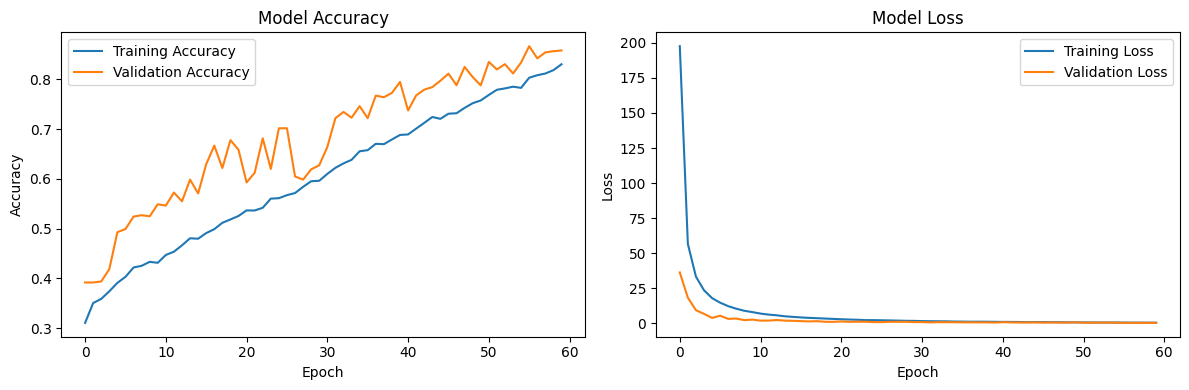

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Helper Functions

In [9]:
import itertools

def batched(iterable, n, *, strict=False):
    # batched('ABCDEFG', 2) → AB CD EF G
    if n < 1:
        raise ValueError('n must be at least one')
    iterator = iter(iterable)
    while batch := tuple(itertools.islice(iterator, n)):
        if strict and len(batch) != n:
            raise ValueError('batched(): incomplete batch')
        yield batch

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import time
import datetime

def get_timestamp():
    ts = time.time()
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

def get_model(params):
    model = EEGCNNLSTM(
        cnn_kernels_1=params['cnn_kernels_1'],
        cnn_kernel_size_1=params['cnn_kernel_size_1'],
        cnn_kernels_2=params['cnn_kernels_2'],
        cnn_dropout=float(params['cnn_dropout']),
        cnn_dense=params['cnn_dense'],
        lstm_hidden_size=params['lstm_hidden_size'],
        lstm_layers=params['lstm_layers'],
        lstm_dense=params['lstm_dense'],
        dropout=float(params['cnn_dropout']),  # use cnn_dropout as a simple shared dropout param
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
    elif params['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
    else:
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=1e-4)

    return model, criterion, optimizer

def get_validation(model, data_loader, device, matrix=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb_eeg, xb_band, yb in data_loader:
            xb_eeg = xb_eeg.to(device)
            xb_band = xb_band.to(device)
            preds = model(xb_eeg, xb_band).argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds) if matrix else None

    return acc, report, conf_matrix

def get_dataset(df, is_train=False, batch_size=36):
    frequency_count = len(df['Frequency'].unique())
    window_count = len(df['Window'].unique())
    numeric_df = df.drop(['ID', 'Window'], axis=1)

    # shape: (windows, freqs, features)
    full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

    X = full_ndarray[:, :, 2:]     # drop ID/Class columns
    y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

    # Add channel dimension (N, 1, freq, electrodes)
    X = X[..., np.newaxis]          # (N, freq, electrodes, 1)

    print(X.shape)

    return DataLoader(EEGDataset(X, y), batch_size=batch_size, shuffle=is_train)

#### Search Space Definition

In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK

# -------------------------
# Hyperopt search space
# -------------------------
space = {
    'cnn_kernels_1'    : hp.choice('cnn_kernels_1', [16, 32, 48, 64]),
    'cnn_kernel_size_1': hp.choice('cnn_kernel_size_1', [3, 5]),
    'cnn_kernels_2'    : hp.choice('cnn_kernels_2', [16, 32, 64, 96]),
    'cnn_kernel_size_2': hp.choice('cnn_kernel_size_2', [3, 5]),
    'cnn_dropout'      : hp.uniform('cnn_dropout', 0.0, 0.7),
    'cnn_dense'        : hp.choice('cnn_dense', [32, 64, 128, 256]),
    'lstm_hidden_size' : hp.choice('lstm_hidden_size', [32, 64, 96, 128]),
    'lstm_layers'      : hp.choice('lstm_layers', [1, 2, 3, 4, 5, 6]),
    'lstm_dense'       : hp.choice('lstm_dense', [32, 64, 128, 256]),
    'learning_rate'    : hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'optimizer'        : hp.choice('optimizer', ['adam', 'rmsprop', 'sgd']),
    'batch_size'       : hp.choice('batch_size', [32, 36, 48, 64, 80, 96])
}

#### Search Objective Definition

In [12]:
import itertools

# -------------------------
# k-Fold CV for Hyperopt
# -------------------------
def objective(params):
    print("Trial params:", params)

    criterion = nn.CrossEntropyLoss()
    unique_subjects = df['ID'].unique()
    losses = []
    variances = []
    batch_size = params['batch_size']

    K_FOLDS = 5
    fold_size = len(unique_subjects) // K_FOLDS

    cyclic = itertools.cycle(unique_subjects)
    batched_cyclic = batched(cyclic, n=fold_size)
    folds = itertools.islice(batched_cyclic, K_FOLDS)

    for i, fold in enumerate(folds):
        print(f"Starting fold {i + 1}/{K_FOLDS}")

        train_df = df[~df['ID'].isin(fold)]
        test_df  = df[df['ID'].isin(fold)]

        print(train_df.shape, test_df.shape)

        train_loader = get_dataset(train_df, batch_size=batch_size)
        test_loader  = get_dataset(test_df, batch_size=batch_size)
        model, criterion, optimizer = get_model(params)

        # Train with modest epochs; early stopping inside fit handles rest
        history = model.fit(
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=60,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            patience=15
        )

        acc, *_ = get_validation(model, test_loader, device)
        loss = history['val_losses']
        mean_loss = np.min(loss)
        losses.append(mean_loss)

        last_5_or_less = history["val_losses"]
        last_5_or_less = last_5_or_less[-min(len(last_5_or_less), 5):]
        variance = np.var(last_5_or_less) if len(last_5_or_less) > 1 else 1
        variances.append(variance)

        print(f"Fold {i + 1} Accuracy:", acc)

    loss = np.mean(losses)
    tail_variance = np.var(variances)
    print(variances)
    score = loss + tail_variance

    print(f"k-Fold CV Mean Loss: {loss:.4f} ± {np.std(losses):.4f}")
    print(f"k-Fold CV Tail Variance: {tail_variance:.4f}")

    # Hyperopt minimizes -> return negative accuracy
    return {'loss': score, 'status': STATUS_OK, 'attachments': {'history': history}}


In [18]:
# -------------------------
# Single Objective for Hyperopt
# -------------------------
def objective(params):
    print("Trial params:", params)

    # build dataloaders from the existing train_ds/test_ds in this session
    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=params['batch_size'], shuffle=False)

    # create model (note we pass dropout into lstm dropout and cnn dropout)
    model, criterion, optimizer = get_model(params)

    # Train with modest epochs; early stopping inside fit handles rest
    history = model.fit(
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=60,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        patience=10
    )

    best_val_loss = float(np.min(history['val_losses'])) if len(history['val_losses']) > 0 else 0.0

    # Hyperopt minimizes -> return negative accuracy
    return {'loss': best_val_loss, 'status': STATUS_OK, 'attachments': {'history': history, 'best_val_loss': best_val_loss}}


#### Hyperparameter Search

In [19]:
from hyperopt import Trials, fmin

def hyperparameter_search(max_evals=30):
    trials = Trials()
    
    print("Starting TPE search...")
    t0 = time.time()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,   # increase for more thorough search
        trials=trials
    )
    
    print("Best hyperparameters:", best)
    t1 = time.time()
    duration = t1 - t0
    print(f"TPE search finished in {duration:.2f} seconds")
    print("Best (raw indices):", best)
    
    # Convert choice indices back to values for readability:
    def choice_value(key, val):
        mapping = {
            'cnn_kernels_1': [16, 32, 48, 64],
            'cnn_kernel_size_1': [3, 5],
            'cnn_kernels_2': [16, 32, 64, 96],
            'cnn_kernel_size_2': [3, 5],
            'cnn_dense': [32, 64, 128, 256],
            'lstm_hidden_size': [32, 64, 96, 128],
            'lstm_layers': [1, 2, 3, 4, 5, 6],
            'lstm_dense': [32, 64, 128, 256],
            'optimizer': ['adam', 'rmsprop', 'sgd'],
            'batch_size': [32, 36, 48, 64, 80, 96]
        }
        return mapping[key][int(val)] if key in mapping else val
    
    readable = {k: choice_value(k, v) if k in ['cnn_kernels_1','cnn_kernel_size_1','cnn_kernels_2',
                                               'cnn_kernel_size_2', 'cnn_dense','lstm_hidden_size',
                                               'lstm_layers','lstm_dense','optimizer','batch_size'] else v
                for k,v in best.items()}
    print("Best (interpreted):", readable)

    params = dict(readable)
    params['cnn_kernels_1'] = int(params['cnn_kernels_1'])
    params['cnn_kernel_size_1'] = int(params['cnn_kernel_size_1'])
    params['cnn_kernels_2'] = int(params['cnn_kernels_2'])
    params['cnn_kernel_size_2'] = int(params['cnn_kernel_size_2'])
    params['cnn_dense'] = int(params['cnn_dense'])
    params['lstm_hidden_size'] = int(params['lstm_hidden_size'])
    params['lstm_layers'] = int(params['lstm_layers'])
    params['lstm_dense'] = int(params['lstm_dense'])
    params['batch_size'] = int(params['batch_size'])
    params['cnn_dropout'] = float(params['cnn_dropout'])
    params['dropout'] = float(params['cnn_dropout'])

    return trials, params

In [15]:
trials, params = hyperparameter_search()
with open("best_parameters.json", "w+") as f:
    import json
    json.dump(params, f, indent=4)

Starting TPE search...
Trial params:                                                                                                           
{'batch_size': 96, 'cnn_dense': 128, 'cnn_dropout': 0.6428092194630661, 'cnn_kernel_size_1': 5, 'cnn_kernel_size_2': 5, 'cnn_kernels_1': 32, 'cnn_kernels_2': 64, 'learning_rate': 0.00011678133243159471, 'lstm_dense': 32, 'lstm_hidden_size': 32, 'lstm_layers': 6, 'optimizer': 'sgd'}
Epoch 001 | Train Loss: 9.8554 Acc: 0.3809 | Val Loss: 0.9777 Acc: 0.5370                                               
Epoch 002 | Train Loss: 1.0547 Acc: 0.4644 | Val Loss: 0.9393 Acc: 0.5522                                               
Epoch 003 | Train Loss: 1.0193 Acc: 0.4723 | Val Loss: 0.9112 Acc: 0.5433                                               
Epoch 004 | Train Loss: 1.0000 Acc: 0.4708 | Val Loss: 0.8897 Acc: 0.5716                                               
Epoch 005 | Train Loss: 0.9991 Acc: 0.4773 | Val Loss: 0.8779 Acc: 0.6137                

NameError: name 'json' is not defined

In [20]:
trial_results = []

for i in range(10):
    trials, params = hyperparameter_search()
    trial_results.append({"trials": trials, "params": params})

Starting TPE search...
Trial params:                                                                                                           
{'batch_size': 48, 'cnn_dense': 64, 'cnn_dropout': 0.1793512885568253, 'cnn_kernel_size_1': 5, 'cnn_kernel_size_2': 5, 'cnn_kernels_1': 64, 'cnn_kernels_2': 32, 'learning_rate': 2.849957138409511e-05, 'lstm_dense': 128, 'lstm_hidden_size': 96, 'lstm_layers': 2, 'optimizer': 'adam'}
Epoch 001 | Train Loss: 102.2467 Acc: 0.3460 | Val Loss: 33.2389 Acc: 0.4469                                            
Epoch 002 | Train Loss: 45.8676 Acc: 0.3631 | Val Loss: 12.7050 Acc: 0.4155                                             
Epoch 003 | Train Loss: 30.8543 Acc: 0.3900 | Val Loss: 9.5081 Acc: 0.3501                                              
Epoch 004 | Train Loss: 21.3121 Acc: 0.4073 | Val Loss: 7.0657 Acc: 0.3755                                              
Epoch 005 | Train Loss: 16.4363 Acc: 0.4153 | Val Loss: 4.9482 Acc: 0.3860               

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 047 | Train Loss: 0.7509 Acc: 0.6330 | Val Loss: 0.6963 Acc: 0.6713                                               
Epoch 048 | Train Loss: 0.7648 Acc: 0.6337 | Val Loss: 0.6753 Acc: 0.7179                                               
Epoch 049 | Train Loss: 0.7556 Acc: 0.6367 | Val Loss: 0.6998 Acc: 0.6684                                               
Epoch 050 | Train Loss: 0.7415 Acc: 0.6413 | Val Loss: 0.6714 Acc: 0.7460                                               
Epoch 051 | Train Loss: 0.7630 Acc: 0.6384 | Val Loss: 0.6866 Acc: 0.7281                                               
Epoch 052 | Train Loss: 0.7497 Acc: 0.6425 | Val Loss: 0.6800 Acc: 0.7081                                               
Epoch 053 | Train Loss: 0.7456 Acc: 0.6449 | Val Loss: 0.6802 Acc: 0.6901                                               
Epoch 054 | Train Loss: 0.7460 Acc: 0.6410 | Val Loss: 0.6760 Acc: 0.6910                                               
Epoch 055 | Train Loss: 0.7371 A

TypeError: Object of type Trials is not JSON serializable

In [27]:
import json
import numpy as np
from datetime import datetime


def to_json_safe(obj):
    """Recursively convert objects to JSON-serializable types."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, datetime):
        return obj.isoformat()
    if isinstance(obj, dict):
        return {k: to_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_json_safe(v) for v in obj]
    return obj


def serialize_trial(trial):
    """Extract only JSON-safe and meaningful parts of a Hyperopt Trial."""
    print(trial.attachments)
    return {
        "attachments": to_json_safe(trial.attachments)
    }


# ===============================
# DROP-IN REPLACEMENT STARTS HERE
# ===============================

json_results = []

for entry in trial_results:
    json_results.append({
        "params": to_json_safe(entry.get("params")),
        "trial": serialize_trial(entry.get("trials")),
    })

with open("all_trials.json", "w", encoding="utf-8") as f:
    json.dump(
        {"results": json_results},
        f,
        indent=4,
        ensure_ascii=False
    )

{'ATTACH::0::history': {'train_accs': array([0.34599597, 0.3630868 , 0.38995447, 0.4072692 , 0.41525487,
       0.4153295 , 0.42674826, 0.42585268, 0.42973356, 0.43674901,
       0.44212255, 0.44466005, 0.45204866, 0.47451302, 0.47339354,
       0.48234943, 0.48824539, 0.49652959, 0.5039182 , 0.51235167,
       0.51690425, 0.52212852, 0.53675647, 0.53780133, 0.53638331,
       0.54705575, 0.55145906, 0.56422121, 0.56272856, 0.57631167,
       0.58220763, 0.58511829, 0.5876558 , 0.59773117, 0.60810508,
       0.61004553, 0.60788119, 0.62803194, 0.63206209, 0.64780954,
       0.64370475, 0.66124338, 0.66415404, 0.67758788, 0.67773714,
       0.69132025, 0.6949026 , 0.70027614, 0.71572505, 0.71863572,
       0.73415927, 0.73624897, 0.73774162, 0.74796627, 0.7531159 ,
       0.76281812, 0.7699082 , 0.77281887, 0.78043138, 0.78953653]), 'train_losses': array([102.24673   ,  45.86756107,  30.85426743,  21.31211104,
        16.43628355,  14.0938445 ,  11.95519647,  10.34000997,
         9.120

Visualization complete. Best trial found at index 1.


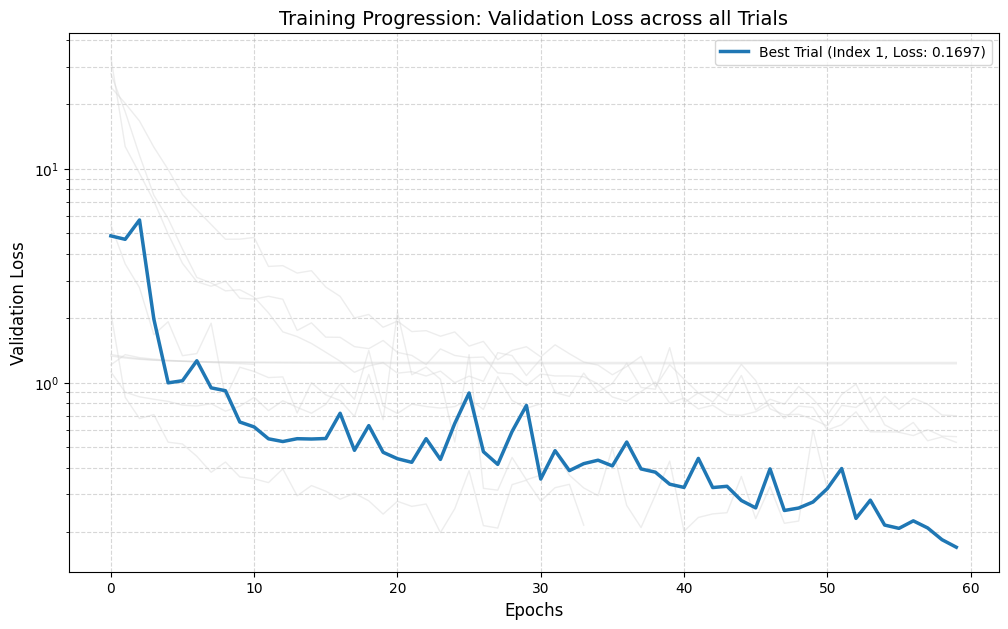

In [33]:
import json
import matplotlib.pyplot as plt

def visualize_trials(file_path):
    # 1. Load the JSON data
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    results = data.get('results', [])
    all_val_losses = []
    best_overall_loss = float('inf')
    best_trial_index = -1

    # 2. Extract losses and identify the best trial
    for i, entry in enumerate(results):
        attachments = entry.get('trial', {}).get('attachments', {})
        # The history key follows the pattern "ATTACH::[index]::history"
        history_key = f"ATTACH::{i}::history"
        
        if history_key in attachments:
            val_losses = attachments[history_key].get('val_losses', [])
            all_val_losses.append(val_losses)
            
            # Check if this trial contains the best (lowest) loss seen so far
            if val_losses:
                min_loss = min(val_losses)
                if min_loss < best_overall_loss:
                    best_overall_loss = min_loss
                    best_trial_index = i

    # 3. Create the plot
    plt.figure(figsize=(12, 7))
    
    # Plot all trials in a muted light gray
    for i, losses in enumerate(all_val_losses):
        if i == best_trial_index:
            continue  # Skip the best one to plot it last (on top)
        plt.plot(losses, color='lightgray', alpha=0.4, linewidth=1)

    # Highlight the best trial in a bold color
    if best_trial_index != -1:
        plt.plot(all_val_losses[best_trial_index], 
                 color='#1f77b4',  # Professional blue
                 linewidth=2.5, 
                 label=f'Best Trial (Index {best_trial_index}, Loss: {best_overall_loss:.4f})')

    # 4. Formatting
    plt.title('Training Progression: Validation Loss across all Trials', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Validation Loss', fontsize=12)
    
    # Use log scale if there is a massive range in loss values
    plt.yscale('log') 
    
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend()
    
    print(f"Visualization complete. Best trial found at index {best_trial_index}.")
    plt.show()

if __name__ == "__main__":
    # Ensure 'test.json' is in the same directory as this script
    visualize_trials('all_trials.json')

In [3]:
import json

def extract_best_params(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        best_overall_loss = float('inf')
        best_params = None
        best_trial_index = -1

            
        # Iterate through the results list
        for i, entry in enumerate(data.get('results')):
            params = entry.get('params')
            attachments = entry.get('trial', {}).get('attachments', {})
            # The history key follows the pattern "ATTACH::[index]::history"
            history_key = f"ATTACH::{i}::history"
            
            if history_key in attachments:
                val_losses = attachments[history_key].get('val_losses', [])
                
                # Check if this trial contains the best (lowest) loss seen so far
                if val_losses:
                    min_loss = min(val_losses)
                    if min_loss < best_overall_loss:
                        best_overall_loss = min_loss
                        best_trial_index = i
                        best_params = params
        
        if best_params:
            print(f"--- Best Trial Found ---")
            print(f"Index: {best_trial_index}")
            print(f"Lowest Loss: {best_overall_loss}")
            print(f"Parameters: {json.dumps(best_params, indent=4)}")

            return best_params
        else:
            print("No valid loss data found in the JSON file.")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except json.JSONDecodeError:
        print("Error: Failed to decode JSON. Check the file format.")

best_params = extract_best_params('all_trials.json')

--- Best Trial Found ---
Index: 1
Lowest Loss: 0.16972512834107698
Parameters: {
    "batch_size": 96,
    "cnn_dense": 128,
    "cnn_dropout": 0.23288671170703942,
    "cnn_kernel_size_1": 3,
    "cnn_kernel_size_2": 5,
    "cnn_kernels_1": 64,
    "cnn_kernels_2": 96,
    "learning_rate": 0.0006894204402451877,
    "lstm_dense": 128,
    "lstm_hidden_size": 128,
    "lstm_layers": 2,
    "optimizer": "rmsprop",
    "dropout": 0.23288671170703942
}


In [35]:
# build dataloaders from the existing train_ds/test_ds in this session
train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=best_params['batch_size'], shuffle=False)

# create model (note we pass dropout into lstm dropout and cnn dropout)
model, criterion, optimizer = get_model(best_params)

# Train with modest epochs; early stopping inside fit handles rest
history = model.fit(
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=60,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    patience=10
)
acc, report, matrix = get_validation(model, test_loader, device)

print("\nval Accuracy:", acc)
print(report)
print(matrix)

Epoch 001 | Train Loss: 9.5466 Acc: 0.4097 | Val Loss: 4.5989 Acc: 0.4812
Epoch 002 | Train Loss: 2.6209 Acc: 0.4648 | Val Loss: 1.9507 Acc: 0.5152
Epoch 003 | Train Loss: 1.5912 Acc: 0.5010 | Val Loss: 0.9348 Acc: 0.5528
Epoch 004 | Train Loss: 1.0375 Acc: 0.5688 | Val Loss: 0.9115 Acc: 0.5982
Epoch 005 | Train Loss: 0.8210 Acc: 0.6212 | Val Loss: 0.6380 Acc: 0.6779
Epoch 006 | Train Loss: 0.7240 Acc: 0.6656 | Val Loss: 0.5834 Acc: 0.7588
Epoch 007 | Train Loss: 0.6537 Acc: 0.7011 | Val Loss: 0.5510 Acc: 0.7528
Epoch 008 | Train Loss: 0.6154 Acc: 0.7195 | Val Loss: 0.4918 Acc: 0.7633
Epoch 009 | Train Loss: 0.5657 Acc: 0.7398 | Val Loss: 0.4352 Acc: 0.7934
Epoch 010 | Train Loss: 0.5396 Acc: 0.7580 | Val Loss: 0.4970 Acc: 0.7403
Epoch 011 | Train Loss: 0.5102 Acc: 0.7765 | Val Loss: 0.4686 Acc: 0.7893
Epoch 012 | Train Loss: 0.4890 Acc: 0.7851 | Val Loss: 0.4501 Acc: 0.7928
Epoch 013 | Train Loss: 0.5075 Acc: 0.7824 | Val Loss: 0.4445 Acc: 0.8239
Epoch 014 | Train Loss: 0.4700 Acc: 0.

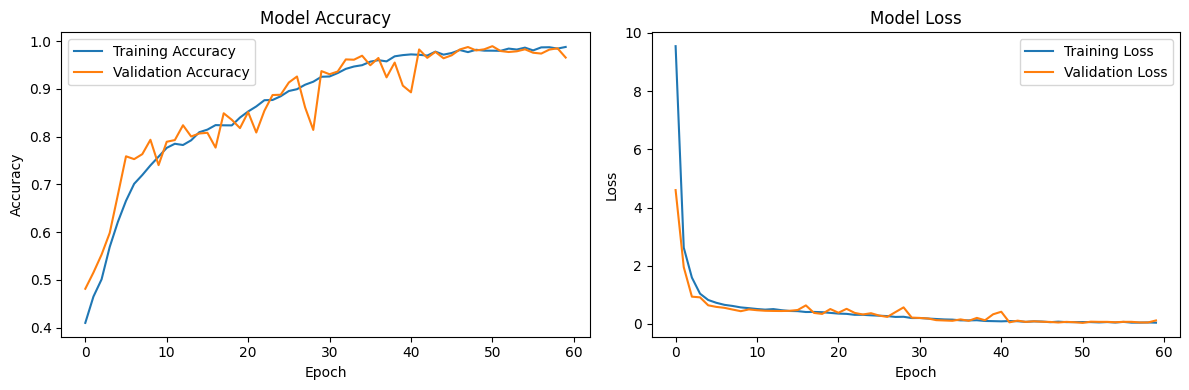

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import random

# map params to integers where needed
params = {'batch_size': 64, 'cnn_dense': 256, 'cnn_dropout': np.float64(0.3571401842400106), 'cnn_kernel_size_1': 5, 'cnn_kernel_size_2': 3, 'cnn_kernels_1': 32, 'cnn_kernels_2': 16, 'learning_rate': np.float64(1.8587640600578385e-05), 'lstm_dense': 64, 'lstm_hidden_size': 96, 'lstm_layers': 2, 'optimizer': 'sgd'}

criterion = nn.CrossEntropyLoss()
unique_subjects = list(df['Window'].unique())
accs = []
variances = []
batch_size = params['batch_size']

K_FOLDS = 11
fold_size = len(unique_subjects) // K_FOLDS

random.shuffle(unique_subjects)

cyclic = itertools.cycle(unique_subjects)
batched_cyclic = batched(cyclic, n=fold_size)
folds = itertools.islice(batched_cyclic, K_FOLDS)
    
for i, fold in enumerate(folds):
    print(f"Starting fold {i + 1}/{K_FOLDS}")

    train_df = df[~df['Window'].isin(fold)]
    test_df   = df[df['Window'].isin(fold)]

    train_loader = get_dataset(train_df, batch_size=batch_size)
    test_loader  = get_dataset(test_df, batch_size=batch_size)
    model, criterion, optimizer = get_model(params)

    # Train with modest epochs; early stopping inside fit handles rest
    history = model.fit(
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=100,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        patience=15
    )

    acc, *_ = get_validation(model, test_loader, device)
    accs.append(acc)

    print(f"Fold {i + 1} Accuracy:", acc)

print(f"k-Fold CV Mean Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

In [ ]:
import random

params = readable

unique_samples = list(df['Window'].unique())
subject_count = df['ID'].nunique()
accs = []
variances = []
batch_size = params['batch_size']

fold_size = len(unique_samples) // subject_count
random.shuffle(unique_samples)

cyclic = itertools.cycle(unique_samples)
batched_cyclic = batched(cyclic, n=fold_size)
folds = itertools.islice(batched_cyclic, subject_count)

for i, fold in enumerate(folds):
    print(f"[{get_timestamp()}] Starting fold {i + 1}/{subject_count}")

    train_df = df[~df['Window'].isin(fold)]
    test_df   = df[df['Window'].isin(fold)]

    train_loader = get_dataset(train_df, is_train=True, batch_size=batch_size)
    test_loader  = get_dataset(test_df, is_train=False, batch_size=batch_size)
    model, criterion, optimizer = get_model(params)

    # Train with modest epochs; early stopping inside fit handles rest
    history = model.fit(
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=60,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        patience=15
    )

    acc, *_ = get_validation(model, test_loader, device)
    accs.append(acc)

    print(f"Fold {i + 1} Accuracy:", acc)

print(f"LOSOCV Mean Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

In [ ]:

params = {'batch_size': 48, 'cnn_dense': 64, 'cnn_dropout': np.float64(0.5130373328759822), 'cnn_kernel_size_1': 5, 'cnn_kernel_size_2': 5, 'cnn_kernels_1': 16, 'cnn_kernels_2': 16, 'learning_rate': np.float64(0.000462968156587811), 'lstm_dense': 256, 'lstm_hidden_size': 128, 'lstm_layers': 1, 'optimizer': 'adam'}

df = pd.read_csv("./processed_clustered_adhdata.csv")

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

display(df.head())

# shape: (windows, frequencies, electrodes)
full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

X = full_ndarray[:, :, 2:]     # drop ID/Class columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

print(X_train.shape)

print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)
train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

unique_samples = list(df['Window'].unique())
subject_count = df['ID'].nunique()
accs = []
variances = []
batch_size = params['batch_size']

model, criterion, optimizer = get_model(params)

# Train with modest epochs; early stopping inside fit handles rest
history = model.fit(
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=60,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    patience=15
)

acc, *_ = get_validation(model, test_loader, device)
accs.append(acc)

print(f"Fold {i + 1} Accuracy:", acc)

print(f"LOSOCV Mean Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

In [ ]:
acc, report, matrix = get_validation(model, test_loader, device)

print("\nval Accuracy:", acc)
print(report)
print(matrix)